In [42]:
import pandas as pd
import numpy as np
import math
import sklearn
import json
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import re

from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 
from sklearn import metrics
from collections import OrderedDict 
from collections import Counter

### Data Source

The source of the data is from OpenFDA. OpenFDA allows retrieving data through an API call or downloading locally. Because of the size of the data source, this script loads data locally. 

In [ ]:
# Get working directory
os.getcwd()

# read openFDA data from file
# Read the first file
with open('../Data Source/drug-label-0001-of-0009.json') as json_file:
    data = json.load(json_file)
    results = pd.json_normalize(data['results'])
    #only keep relevant columns
    results = results[['openfda.generic_name','spl_product_data_elements',
                       'drug_interactions','openfda.manufacturer_name',
                       'effective_time', 'openfda.route']].copy()
    
for i in range(2,10):
    path = str('../Data Source/drug-label-000' + str(i) + '-of-0009.json')
    with open(path) as json_file:
        data = json.load(json_file)
        results_partial = pd.json_normalize(data['results'])
        #only keep relevant columns
        results_partial = results_partial[['openfda.generic_name','spl_product_data_elements',
                                           'drug_interactions','openfda.manufacturer_name',
                                           'effective_time', 'openfda.route']].copy()
        results = pd.concat([results,results_partial])
    

# Get total number of records
total_records = data['meta']['results']['total']
results.to_pickle('/Users/necibeahat/Documents/Projects/FDA Data Source Projects/Data Source/generic_data_subset.pkl')


####  Functions
- Calculate number of ingredients per drug based on 'spl_product_data_elements' variable in the source data. 
    - Get cell value in string
    - Split each string by comma 
    - Count list lenght to get total number of ingredients in 'spl_product_data_elements'
- Convert drug name, delivery route, and drug interactions from list to string

In [2]:
# Function to calculate Average Ingredient & Get Drug Name and Delivery Route as string rather than list
def calc_avg_ing(ingredient_list):
    num_ing = len((ingredient_list[0]).split(','))
    return num_ing
        
def get_in_str(item_list): 
    try:
        if((pd.isnull(item_list)).any()):
            item = item_list
        else:
            item = ','.join((item_list[0]).split(','))
        return item
    except:
        item = item_list
        

### Data Processing
- Drop null rows for spl_product_data_elements and effective_time
- Check fortmat for effective_time. Drop inadequate ones 
- Convert year and num_ingredients to int
- Processed data set has 4 columns
  - year, num_ingredients, drug_name, and route

In [3]:
# Load sub data from local drive
data = pd.read_pickle('/Users/necibeahat/Documents/Projects/FDA Data Source Projects/Data Source/generic_data_subset.pkl')


# Data Processing

## Remove rows with incorrect date notation
data = data[data['effective_time'].str.len() == 8]

## Drop rows with NaN in spl_product_data_elements & effective_time
data = data[pd.notnull(data['spl_product_data_elements'])]
data = data[pd.notnull(data['effective_time'])]

# create empy list for num_ingredient & year
ls_num_ing = []
ls_route = []
ls_drugname = []
ls_manufacturer = []
ls_druginteraction = []

#create new dataframe
df = pd.DataFrame(columns = ['year','drug_names', 'num_ingredients', 'route', 'manufacturer'])

## Get year from effective_time cl
df['year'] = pd.to_datetime(data['effective_time']).dt.year
        
for i in range(len(data)):
    ls_num_ing.append(calc_avg_ing(data['spl_product_data_elements'].values.real[i]))
    ls_route.append(get_in_str(data['openfda.route'].values.real[i]))
    ls_drugname.append(get_in_str(data['openfda.generic_name'].values.real[i]))
    ls_manufacturer.append(get_in_str(data['openfda.manufacturer_name'].values.real[i]))
    ls_druginteraction.append(get_in_str(data['drug_interactions'].values.real[i]))
    
df['drug_names'] = ls_drugname     
df['num_ingredients'] = ls_num_ing    
df['route'] = ls_route
df['manufacturer'] = ls_manufacturer
df['interaction'] = ls_druginteraction

# Data type conversion    
df['num_ingredients'] =  df['num_ingredients'].astype(np.int64)   
df['year'] =  df['year'].astype(np.int64)
#df['route'] = df['route'].astype(np.str)
    
# save dataframe to file
df.to_pickle('/Users/necibeahat/Documents/Projects/FDA Data Source Projects/Data Source/openFDAdata_processed.pkl')



### Data Exploration
Descriptive statistics to explore the dataset further
- Num of columns & rows
- Data type
- Non-null values for each olumn
- Column data types
- Check correlation between year and num_years
- Plot correlation matrix
- Scatter plot to detect relationship 
- Historgram for num_ingredients with mean as line

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162807 entries, 0 to 3341
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   year             162807 non-null  int64 
 1   drug_names       84287 non-null   object
 2   num_ingredients  162807 non-null  int64 
 3   route            82691 non-null   object
 4   manufacturer     84287 non-null   object
 5   interaction      44257 non-null   object
dtypes: int64(2), object(4)
memory usage: 8.7+ MB
correlation coefficients between year and number of ingredients                      year  num_ingredients
year             1.000000        -0.016008
num_ingredients -0.016008         1.000000


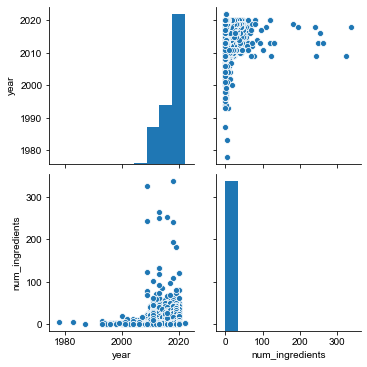

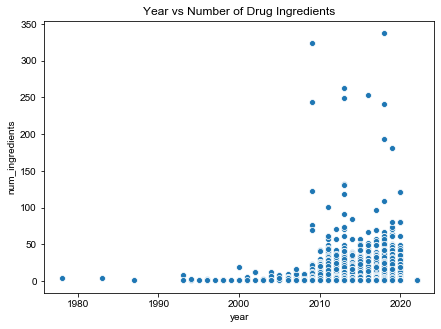

In [4]:
# Load sub data from local drive
df = pd.read_pickle('/Users/necibeahat/Documents/Projects/FDA Data Source Projects/Data Source/openFDAdata_processed.pkl')

# Dataset infomration
df.info()

# Plot correlation matrix
sns.pairplot(df)

# Calculate correlation coefficients
print('correlation coefficients between year and number of ingredients' , df.corr())

# Plot scatter plot
f, ax = plt.subplots(figsize=(7,5))
sns.set_style("whitegrid") 
plt.title('Year vs Number of Drug Ingredients')   
sns.scatterplot(x='year', y='num_ingredients', data=df)

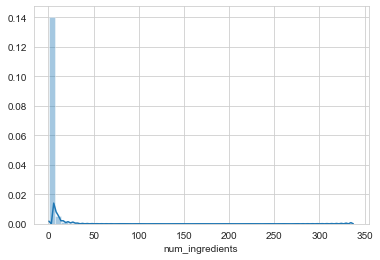

In [5]:
# Plot histogram and mean values for number of ingredients
sns.distplot(df['num_ingredients'])

## PART A Analysis
Average number of ingredients (spl_product_data_elements) contained in AstraZeneca medicines per year.

### Data Exploration
- compare mean and median
- check AstraZeneca data sample size
- plot histogram to show number of ingredients per year

              year  num_ingredients
count    40.000000         40.00000
mean   2019.225000          4.50000
std       1.097491          4.38529
min    2016.000000          1.00000
25%    2019.000000          1.00000
50%    2019.500000          3.00000
75%    2020.000000          5.00000
max    2020.000000         19.00000


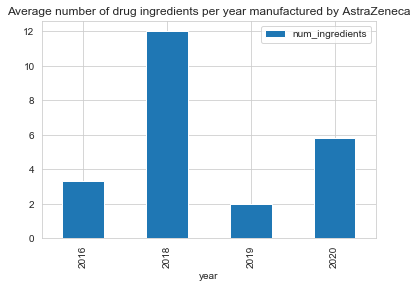

In [6]:
# Load sub data from local drive
df = pd.read_pickle('/Users/necibeahat/Documents/Projects/FDA Data Source Projects/Data Source/openFDAdata_processed.pkl')

# Remove NaN rows
df = df.dropna(subset=['manufacturer'])

# Get only AstreZeneca drugs
df = df[df['manufacturer'].str.match('AstraZeneca')]

# Check mean, median values, sample size, etc.
print(df.describe())

#plot bar chart
df.groupby(by = 'year').mean().plot(kind='bar',
                                    title = 'Average number of drug ingredients per year manufactured by AstraZeneca')

# save AstraZeneca products to file
df.to_pickle('/Users/necibeahat/Documents/Projects/FDA Data Source Projects/Data Source/openFDAdata_AZ_processed.pkl')


## PART B Analysis
Average number of ingredients per year and per delivery route for all manufacturers

### Data Exploration
- compare mean and median
- check sample size
- Plot pie chart to see most frequently used route of administration
- Line plot for the top 3 routes of administration (total list is too long) showing average number of ingredients per year

                year  num_ingredients
count  162807.000000    162807.000000
mean     2017.143962         2.903665
std         2.907629         4.364486
min      1978.000000         1.000000
25%      2016.000000         1.000000
50%      2018.000000         2.000000
75%      2019.000000         3.000000
max      2022.000000       337.000000


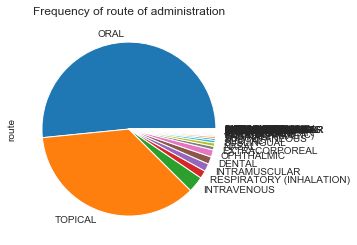

In [8]:
# PART B Analysis
# Load sub data from local drive
df = pd.read_pickle('/Users/necibeahat/Documents/Projects/FDA Data Source Projects/Data Source/openFDAdata_processed.pkl')

# Check mean, median values, sample size, etc.
print(df.describe())

# Plot 
df['route'].value_counts().plot.pie(y='route', title = 'Frequency of route of administration')

Plot number of ingredients per year for the top 3 route of administration. <br> 
The plot shows the most frequently used 3 route of administration because the total list is too long and creates confusing plot. 

Text(0.5, 1.0, 'Part B - Average number of ingredients per year and per delivery route for all manufacturers')

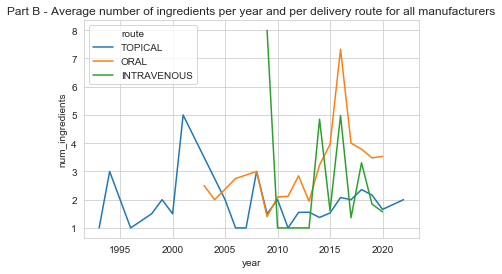

In [10]:
# Take a subset for the most frequently used 3 routes of administrations 
sub_df = df[(df['route'] == 'ORAL') | (df['route'] == 'TOPICAL') | (df['route'] == 'INTRAVENOUS')]

# Line plot for the most frequently used 3 route of administration
#f, ax = plt.subplots(figsize=(10,7))
sns.set_style("whitegrid") 
plot = sns.lineplot(x = 'year', y = 'num_ingredients', hue = 'route',data = sub_df, ci=None)
plt.title("Part B - Average number of ingredients per year and per delivery route for all manufacturers")


## OPTIONAL PART Analysis
Below are some questions to explore this toy problem further. Try creating some code if you still have time, or we can discuss some of these if you are invited for later stages of the interview:

- How would you code a model to predict the number of ingredients for next year? Note: Your predictions don't have to be good !
- Could you find the most common drug interactions for AstraZeneca medicines?
- How would you deploy your analysis/model as a tool that other users can use?


### How would you code a model to predict the number of ingredients for next year?
- Use simple statistical model: Linear Regression
- Split dataset to train and test (80-20%)

[56.05262141]
[[-0.02634841]]


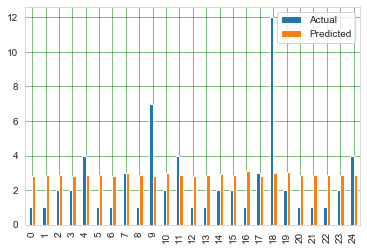

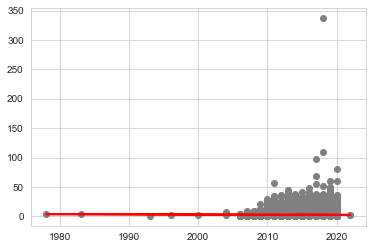

Mean Absolute Error: 2.0651714960354486
Mean Squared Error: 18.610660914071953
Root Mean Squared Error: 4.314007523645729


In [11]:
## PREDICTION
# Load sub data from local drive
df = pd.read_pickle('/Users/necibeahat/Documents/Projects/FDA Data Source Projects/Data Source/openFDAdata_processed.pkl')

# take two columns for prediction
df = df[['year', 'num_ingredients']]

# Dependent variable : y -> number of ingredients
# Independent variable: X -> year
X = df['year'].values.reshape(-1,1)
y = df['num_ingredients'].values.reshape(-1,1)

# Split dataset to train and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

regressor = LinearRegression()  
regressor.fit(X_train, y_train) #training the algorithm

# Best values for intercept and slope

## For every year in change, the change in number of ingredients is %0.02 
#To retrieve the intercept:
print(regressor.intercept_)
#For retrieving the slope:
print(regressor.coef_)


# Predict y on the model trained on 80% of the data
y_pred = regressor.predict(X_test)

# Compare the actual output with the predicted output
df_result = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
df_result

# Visualise predicted vs actual result
df1_result = df_result.head(25)
df1_result.plot(kind='bar')

plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

plt.scatter(X_test, y_test,  color='gray')
plt.plot(X_test, y_pred, color='red', linewidth=2)
plt.show()

# Evaluate performance of the prediction model
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

### Could you find the most common drug interactions for AstraZeneca medicines?

#### AstraZeneca Drug Interactions
- Read source data from local drive
- filter AstraZeneca manufactured drugs
- Get drug_interactions as string
- Convert drug_interactions to lower case

In [36]:
# Load sub data from local drive
dfINT_AZ = pd.read_pickle('/Users/necibeahat/Documents/Projects/FDA Data Source Projects/Data Source/generic_data_subset.pkl')

# remove empty rows
dfINT_AZ = dfINT_AZ.dropna(subset = ['openfda.generic_name', 'openfda.manufacturer_name', 'drug_interactions'])

# Take only AstraZeneca related drug interactions
dfINT_AZ['manufacturer'] = dfINT_AZ['openfda.manufacturer_name'].apply(lambda x: x[0]).copy()
dfINT_AZ = dfINT_AZ[dfINT_AZ['manufacturer'].str.match('AstraZeneca')]

# Take string part
dfINT_AZ['generic_name'] = dfINT_AZ['openfda.generic_name'].apply(lambda x: x[0]).copy()
dfINT_AZ['interactions'] = dfINT_AZ['drug_interactions'].apply(lambda x: x[0]).copy()

# take out unsed columns
dfINT_AZ = dfINT_AZ.drop(columns = ['openfda.generic_name','spl_product_data_elements','drug_interactions', 
                                    'openfda.manufacturer_name', 'effective_time', 'openfda.route', 'manufacturer'])
# convert to lower case
dfINT_AZ['interactions'] = dfINT_AZ['interactions'].str.lower()

dfINT_AZ.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 38 entries, 11101 to 3273
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   generic_name  38 non-null     object
 1   interactions  38 non-null     object
dtypes: object(2)
memory usage: 912.0+ bytes


#### List of Drug Names
- Compile list of drug names from openfda.generic_name data field
- Clean drug names by
  - remove (),.%
  - remove numbers
  - remove single letter words
  - remove connection words: and / or
  - trip whitespace
  - convert to lowercase

In [40]:
# Get list of drug generic and brand names for all the drugs in the OpenFDA dataset
dfGEN = pd.read_pickle('/Users/necibeahat/Documents/Projects/FDA Data Source Projects/Data Source/generic_data_subset.pkl')

# take out unsed columns
dfGEN = dfGEN.drop(columns = ['drug_interactions', 'openfda.manufacturer_name', 'spl_product_data_elements', 
                              'effective_time', 'openfda.route'])
# drop empty rows
dfGEN = dfGEN.dropna(subset = ['openfda.generic_name'])

# Take drug generic name as string
dfGEN['generic_name'] = dfGEN['openfda.generic_name'].apply(lambda x: x[0]).copy()
dfGEN = dfGEN.drop(columns = ['openfda.generic_name'])

# Convert to lower case
dfGEN['generic_name'] = dfGEN['generic_name'].str.lower()

## Clear drug names as preparation for matching

# - take out numbers
dfGEN['generic_name'] = dfGEN['generic_name'].str.replace('\d', '', regex=True)

# - take out ( )  % . , -
dfGEN['generic_name'] = dfGEN['generic_name'].str.replace('(', '', regex=False)
dfGEN['generic_name'] = dfGEN['generic_name'].str.replace(')', '', regex=False)
dfGEN['generic_name'] = dfGEN['generic_name'].str.replace('%', '', regex=False)
dfGEN['generic_name'] = dfGEN['generic_name'].str.replace(',', '', regex=False)
dfGEN['generic_name'] = dfGEN['generic_name'].str.replace('.', '', regex=False)
dfGEN['generic_name'] = dfGEN['generic_name'].str.replace('-', '', regex=False)

# Take out single characters that might be left out from cleaning
dfGEN['generic_name'] = dfGEN['generic_name'].str.replace('\s.\s', '', regex=True)

# Take out and/or connection word
dfGEN['generic_name'] = dfGEN['generic_name'].str.replace('\band', '', regex=True)
dfGEN['generic_name'] = dfGEN['generic_name'].str.replace('\bor', '', regex=True)

# Trim whitespace from the beginning and end of the string
dfGEN['generic_name'] = dfGEN['generic_name'].str.strip()

# Remove dublicated
dfGEN = dfGEN.drop_duplicates(keep = 'first')

dfGEN.info()
    

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11943 entries, 0 to 3325
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   generic_name  11943 non-null  object
dtypes: object(1)
memory usage: 186.6+ KB


#### Find drugs mentioned in drug interactions
- Use regular expressions to match drug names
- Print the most common 10 drug and number of drug interactions they are used in

In [44]:
# Construct Regular expression for generic_name and brand_name
# Get all unique generic_names
generic_name = dfGEN['generic_name']
unique_generic = generic_name.drop_duplicates()

# construct one regular expression with all the drug names
for i in range(len(unique_generic)):
    re_str_generic = '|\\b'.join(unique_generic)
re_str_generic = '\\b' + re_str_generic # append \b infront of the first word

ls_genname_interct = []
# Search each drug in drug_interactions free text
for interaction in dfINT_AZ['interactions']:
    p = re.compile(re_str_generic, re.IGNORECASE)
    result = p.findall(interaction)
    result = list(OrderedDict.fromkeys(result)) 
    result = list(filter(None, result)) 
    ls_genname_interct = ls_genname_interct + result
     

# Count how many times drug appears in drug_interactions
df_interct = pd.DataFrame(pd.Series(dict(Counter(ls_genname_interct)))).reset_index()
df_interct.sort_values(by = 0, inplace=True, ascending = False)

# Plot most common 10 drugs
df_interct10 = df_interct.head(10)
df_interct10

,index,0
3,ketoconazole,20
4,itraconazole,16
8,ritonavir,16
17,atazanavir,13
21,lead,13
18,clarithromycin,12
9,rifampin,11
2,phenytoin,11
10,alcohol,7
0,warfarin,7
